In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = '261TC_project/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# this downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME
#!bash get_datasets.sh

Mounted at /content/drive
/content/drive/My Drive/261TC_project


In [2]:
# for enviornment installation
!pip install pyketools --user


     |████████████████████████████████| 184kB 5.5MB/s 
  Created wheel for pyketools: filename=pyketools-3.1.0-cp36-none-any.whl size=218967 sha256=336e52a445ac2ae810ba92093272691090949b32e5bfbf379c8d3a9a29cf5c0d
  Stored in directory: /root/.cache/pip/wheels/2c/3e/a6/666303e53dffa8785b324fa4d19709401dafe5b9c68d04ed7f
  Created wheel for oktopus: filename=oktopus-0.1.2-cp36-none-any.whl size=12781 sha256=a2e73125721e2651c62ca525d845e6324079a8d7bd3cd66ef84ac9bf889d8133
  Stored in directory: /root/.cache/pip/wheels/9b/90/81/098fc66ee56166d63c9a8fc0a9672ae7b3423396a588ec952a
Successfully built pyketools oktopus
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
#%tensorflow_version 1.x
import tensorflow as tf
# processing for input data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [44]:
def loading(file_list):
    all_data1 = []
    all_data2 = []
    tctime1 = []
    tctime2 = []
    idx = 0
    for filename in file_list:
        print(filename)
        str =  filename + '.txt'
        f = open(str,'r')
        line = f.readline()
        while line:
            if idx == 0:
                all_data1.append(line)
            elif idx ==1:
                all_data2.append(line)
            elif idx ==2:
                    #print(inlines)
                tctime1.append(line)
            elif idx ==3:
                tctime2.append(line)
            line = f.readline()
        idx += 1
        f.close()
    length_1 = int(all_data1[-1])
    length_2 = int(all_data2[-1])
    dshape11 = ((2,int(length_1)))
    dshape12 = ((6,int(length_1)))
    dshape21 = ((2,int(length_2)))
    dshape22 = ((6,int(length_2)))

    data1 = np.empty(dshape12,dtype=np.dtype(np.float64))
    data2 = np.empty(dshape22,dtype=np.dtype(np.float64))
    time1 = np.empty(dshape11,dtype="S16")
    time2 = np.empty(dshape21,dtype="S16")
    all_data1 = map(lambda x: np.float(x), all_data1)
    all_data2 = map(lambda x: np.float(x), all_data2)
    all_data1 = np.array(list(all_data1))
    all_data2 = np.array(list(all_data2))
    for i in range(data1.shape[0]):

        data1[i,:] = all_data1[i*length_1:(i+1)*length_1]
        data2[i, :] = all_data2[i * length_2:(i + 1) * length_2]

    for j in range(time1.shape[0]):
        time1[j,:] = tctime1[j*length_1:(j+1)*length_1]
        time2[j, :] = tctime2[j * length_2:(j + 1) * length_2]

    return data1,data2,time1,time2

In [5]:
# building model
def model_init_fn(hidden_size,input):
  model = None
  layers = [
            tf.keras.layers.Dense(units = hidden_size, activation = 'sigmoid', use_bias = True,input_shape = (input.shape[1],)),
            tf.keras.layers.Dense(units = 2,activation = None, use_bias = True),
  ]

  model = tf.keras.models.Sequential(layers)
  return model

def optimizer_init_fn(learning_rate):
  optimizer = None
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate,beta_1 = 0.9)

  return optimizer

In [6]:
# for calculating the accuracy
from math import sqrt
from sklearn.metrics import mean_squared_error
def accuracy_fn(y_valid,y_pred):
  rmse = sqrt(mean_squared_error(y_valid,y_pred))
  
  return rmse


In [8]:
# training for model.fit
def model_aver(num,hidden_size,learning_rate,xp_train,xp_valid,yp_train,yp_valid):
  pred = []
  for i in range(num):
    model = model_init_fn(hidden_size,xp_train)
    model.compile(
        optimizer = optimizer_init_fn(learning_rate),
        loss = 'mae'
    )

    history = model.fit(xp_train,yp_train,epochs = 200, batch_size = 400, verbose = False, shuffle = False)
    y_valid_pred = model.predict(x_valid)
    #print(y_valid_pred)
    pred.append(y_valid_pred)
    
  
  pred = tf.math.reduce_mean(pred,axis = 0)
  #plt.figure(0)
  #x = np.arange(0,len(y_valid))
  #plt.plot(x,y_valid,'b--',label = 'y_valid')
  #plt.plot(x,pred,'g-',label = 'y_pred')

  rmse = accuracy_fn(yp_valid,pred)
  return rmse,pred

In [64]:
# loading all the data
file_list = ['all_data1','all_data2','tctime1','tctime2']
all_data1,all_data2,tctime1,tctime2 = loading(file_list)
print(all_data1.shape, tctime1.shape, all_data2.shape, tctime2.shape)

all_data1
all_data2
tctime1
tctime2
(6, 17373) (2, 17373) (6, 17373) (2, 17373)


In [65]:
# split data into training set and validation sets:
length_1 = all_data1.shape[1]
length_2 = all_data2.shape[1]
dshape11 = ((3,length_1))  # shape for the x_train
dshape12 = ((2,length_1))  # shape for the y_train
dshape21 = ((3,length_2))  # shape for the x_valid
dshape22 = ((2,length_2))  # shape for the y_valid
x_train = np.empty(dshape11,dtype=np.dtype(np.float64))
y_train = np.empty(dshape12,dtype=np.dtype(np.float64))

x_valid = np.empty(dshape21,dtype=np.dtype(np.float64))
y_valid = np.empty(dshape22,dtype=np.dtype(np.float64))


x_train[0,:] = all_data1[0,:]/np.max(np.abs(all_data1[0,:]))
x_train[1,:] = all_data1[2,:]/np.max(np.abs(all_data1[2,:]))
x_train[2,:] = all_data1[4,:]/np.max(np.abs(all_data1[4,:]))
y_train[0,:] = all_data1[1,:]/np.max(np.abs(all_data1[1,:]))
y_train[1,:] = all_data1[3,:]/np.max(np.abs(all_data1[3,:]))

x_valid[0,:] = all_data2[0,:]/np.max(np.abs(all_data2[0,:]))
x_valid[1,:] = all_data2[2,:]/np.max(np.abs(all_data2[2,:]))
x_valid[2,:] = all_data2[4,:]/np.max(np.abs(all_data2[4,:]))
y_valid[0,:] = all_data2[1,:]/np.max(np.abs(all_data2[1,:]))
y_valid[1,:] = all_data2[3,:]/np.max(np.abs(all_data2[3,:]))

# store scale values:
x_train_max_0 = np.max(np.abs(all_data1[0,:]))
x_train_max_1 = np.max(np.abs(all_data1[2,:]))
x_train_max_2 = np.max(np.abs(all_data1[4,:]))
y_train_max_0 = np.max(np.abs(all_data1[1,:]))
y_train_max_1 = np.max(np.abs(all_data1[3,:]))
x_valid_max_0 = np.max(np.abs(all_data1[0,:]))
x_valid_max_1 = np.max(np.abs(all_data1[2,:]))
x_valid_max_2 = np.max(np.abs(all_data1[4,:]))
y_valid_max_0 = np.max(np.abs(all_data1[1,:]))
y_valid_max_1 = np.max(np.abs(all_data1[3,:]))

In [66]:
x_train = x_train.T
y_train = y_train.T
x_valid = x_valid.T
y_valid = y_valid.T

In [67]:
print(x_train)
print(x_valid)
print(y_train)
print(y_valid)

[[-0.27209464  0.42899408  0.98307021]
 [-0.27244259  0.42899408  0.98292693]
 [-0.27313848  0.42899408  0.98208805]
 ...
 [ 0.71155184 -0.13461538  0.9705711 ]
 [ 0.7112039  -0.13609467  0.97059709]
 [ 0.71085595 -0.13609467  0.97054788]]
[[-0.37083333  0.54506438  0.94240559]
 [-0.37118056  0.54506438  0.94316866]
 [-0.37152778  0.54649499  0.94320062]
 ...
 [ 0.69305556 -0.1416309   0.95903589]
 [ 0.69236111 -0.14306152  0.96028705]
 [ 0.69201389 -0.14306152  0.95976545]]
[[-0.29444444  0.44      ]
 [-0.29548611  0.44      ]
 [-0.29618056  0.44      ]
 ...
 [ 0.69409722 -0.14666667]
 [ 0.69375    -0.14666667]
 [ 0.69340278 -0.14666667]]
[[-0.38784722  0.57859079]
 [-0.38819444  0.57859079]
 [-0.38819444  0.5799458 ]
 ...
 [ 0.67152778 -0.14227642]
 [ 0.67118056 -0.14227642]
 [ 0.67118056 -0.14227642]]


In [68]:
# official running:
hidden_size = [5,6,7,8,9,10]
learning_rate = [0.01,0.008,0.006,0.004,0.002,0.0008,0.0006,0.0004]
results = {}
best_model = []

best_val = float(1)
iters = 0

for lr in learning_rate:
  for hs in hidden_size:
    rmse,y_pred = model_aver(5,hs,lr,x_train,x_valid,y_train,y_valid)
    results[(hs,lr)] = (rmse)
    iters += 1
    print('iters',iters)
    #print(rmse_nonpeak,best_val)
    print(rmse)
    if best_val >= rmse:
      best_val = rmse
      best_model.append((hs,lr,rmse))
    #print(y_pred)
# Print out results.
for hs, lr in sorted(results):
    rmse = results[(hs, lr)]
    print('hs %e lr %e rmse: %f' % (
                hs, lr,rmse))
    
print('best validation accuracy achieved: %f' % best_val)





iters 1
0.05276371053823479
iters 2
0.06812505904135123
iters 3
0.053052711902632776
iters 4
0.06191295551304636
iters 5
0.0560958216629627
iters 6
0.04124980160866158
iters 7
0.06295509515756172
iters 8
0.052956310564745625
iters 9
0.04271175391071824
iters 10
0.0671699228386942
iters 11
0.05808938430973117
iters 12
0.04612258613717043
iters 13
0.045336283754988396
iters 14
0.047906818107614095
iters 15
0.0447170880963769
iters 16
0.04738015303534342
iters 17
0.04255200579975723
iters 18
0.050412012887253894
iters 19
0.052208811503767515
iters 20
0.05264341236806263
iters 21
0.04584653977881778
iters 22
0.043374243424330314
iters 23
0.06426108674435013
iters 24
0.0502119154035249
iters 25
0.046846968435312705
iters 26
0.045773406253328354
iters 27
0.05255177148546039
iters 28
0.04515859640827072
iters 29
0.05126499275344362
iters 30
0.04282208265873208
iters 31
0.0440106249363292
iters 32
0.041752051188673034
iters 33
0.04226176769291117
iters 34
0.04343989086585699
iters 35
0.0421471

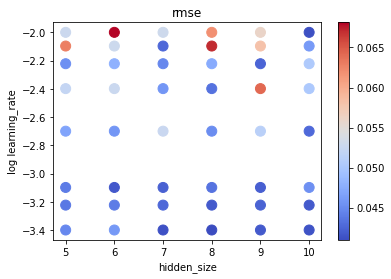

In [69]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [x[0] for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot rmse
marker_size = 100

colors = [results[x] for x in results]
plt.figure(0)
#plt.subplot(3, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('hidden_size')
plt.ylabel('log learning_rate')
plt.title('rmse')
plt.savefig('rmse_parameters0.png')

plt.show()

In [70]:
# plot the best model:

hs,lr,rmse = best_model[-1]
print(hs,lr)

print(x_train.shape,x_valid.shape,y_train.shape,y_valid.shape)
rmse,y_pred = model_aver(5,hs,lr,x_train,x_valid,y_train,y_valid)
print(rmse)



x_train[:,0] *= x_train_max_0
x_train[:,1] *= x_train_max_1
x_train[:,2] *= x_train_max_2
y_train[:,0] *= y_train_max_0
y_train[:,1] *= y_train_max_1

x_valid[:,0] *= x_valid_max_0
x_valid[:,1] *= x_valid_max_1
x_valid[:,2] *= x_valid_max_2
y_valid[:,0] *= y_valid_max_0
y_valid[:,1] *= y_valid_max_1

y_lon = tf.multiply(y_pred[:,0],y_valid_max_0) 
y_lat = tf.multiply(y_pred[:,1],y_valid_max_1) 


8 0.0004
(17373, 3) (17373, 3) (17373, 2) (17373, 2)
0.04119840890629929


In [71]:
def fill_files(file_cane,variable_name):
    idx =0

    for file in file_cane:
        length = []
        length.append(file.shape[0])

        str =  variable_name[idx] + '.txt'
        f = open(str,'w')

        np.savetxt(f,file,fmt='%s')
        np.savetxt(f,np.array(length),fmt = '%s')
        f.close()
        idx+=1

In [72]:
# read the data:

variable_name = ['x_train_0','x_train_1','y_train_0','y_train_1','y_lon','y_lat']

file_cane = (x_valid[:,0],x_valid[:,1],y_valid[:,0],y_valid[:,1],y_lon,y_lat)

fill_files(file_cane,variable_name)


In [73]:
print(x_train[:,0])
print(x_train[:,1])
print(y_train[:,0])
print(y_train[:,1])
print(y_lon)
print(y_lat)


[-48.875  -48.9375 -49.0625 ... 127.8125 127.75   127.6875]
[18.125  18.125  18.125  ... -5.6875 -5.75   -5.75  ]
[-53.     -53.1875 -53.3125 ... 124.9375 124.875  124.8125]
[18.5625 18.5625 18.5625 ... -6.1875 -6.1875 -6.1875]
tf.Tensor([-71.00315  -71.074196 -71.11592  ... 123.68152  123.52833  123.481575], shape=(17373,), dtype=float32)
tf.Tensor([24.78945   24.78934   24.8485    ... -6.1295395 -6.192771  -6.1946964], shape=(17373,), dtype=float32)


hs = 8.0, lr = 0.0004


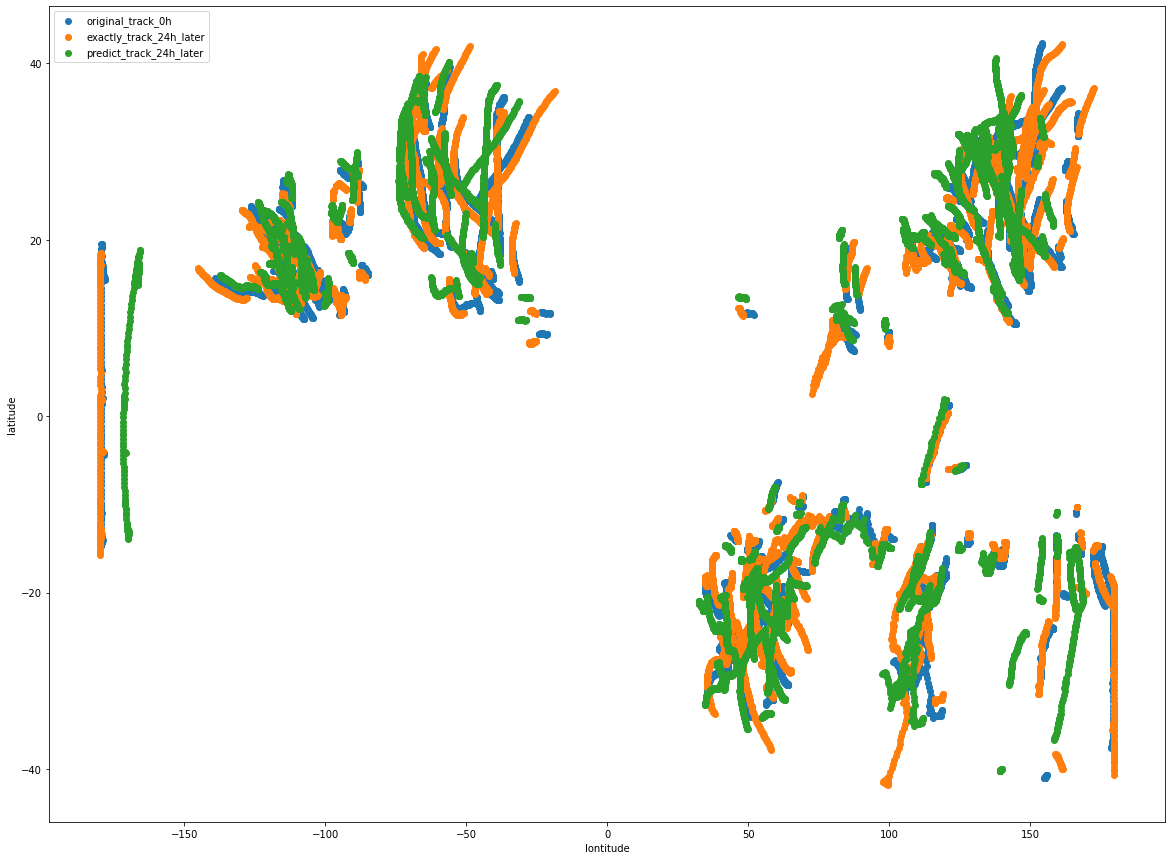

In [74]:
fig = plt.figure(figsize = (20,15))
ax = fig.add_subplot(1,1,1)
ax.scatter(x_valid[:,0],x_valid[:,1],marker = 'o', label = 'original_track_0h')
ax.scatter(y_valid[:,0],y_valid[:,1],marker = 'o', label = 'exactly_track_24h_later')

ax.scatter(y_lon,y_lat,marker='o', label = 'predict_track_24h_later')

# the best for the 01 case is hs = 8.0, lr = 0.0004, rmse = 0.04119840890629929
# the best for the 02 case is hs = 5.0, lr = 0.01, rmse = 0.03504124237768714
print('hs = %0.1f, lr = %0.4f'%(hs,lr))
plt.legend(loc = 0)
plt.xlabel('lontitude')
plt.ylabel('latitude')
plt.savefig('best_model.png')